In [38]:
import numpy as np
import pandas as pd
import imageio
import random
import os
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate, Dropout, UpSampling2D
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import cv2
import seaborn as sns 
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, classification_report

In [39]:
#Create a list that contains all the paths to all directories in the main directory (a list that contains the path to dataA, dataB, dataC, dataD, and dataE)
image_path = ["data/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B']]
mask_path = ["data/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in  ['A', 'B']]

In [40]:
def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths

In [41]:
image_paths = list_image_paths(image_path)
mask_paths = list_image_paths(mask_path)
number_of_images, number_of_masks = len(image_paths), len(mask_paths)
print(f"There are {number_of_images} images and {number_of_masks} masks in dataset")

There are 2000 images and 2000 masks in dataset


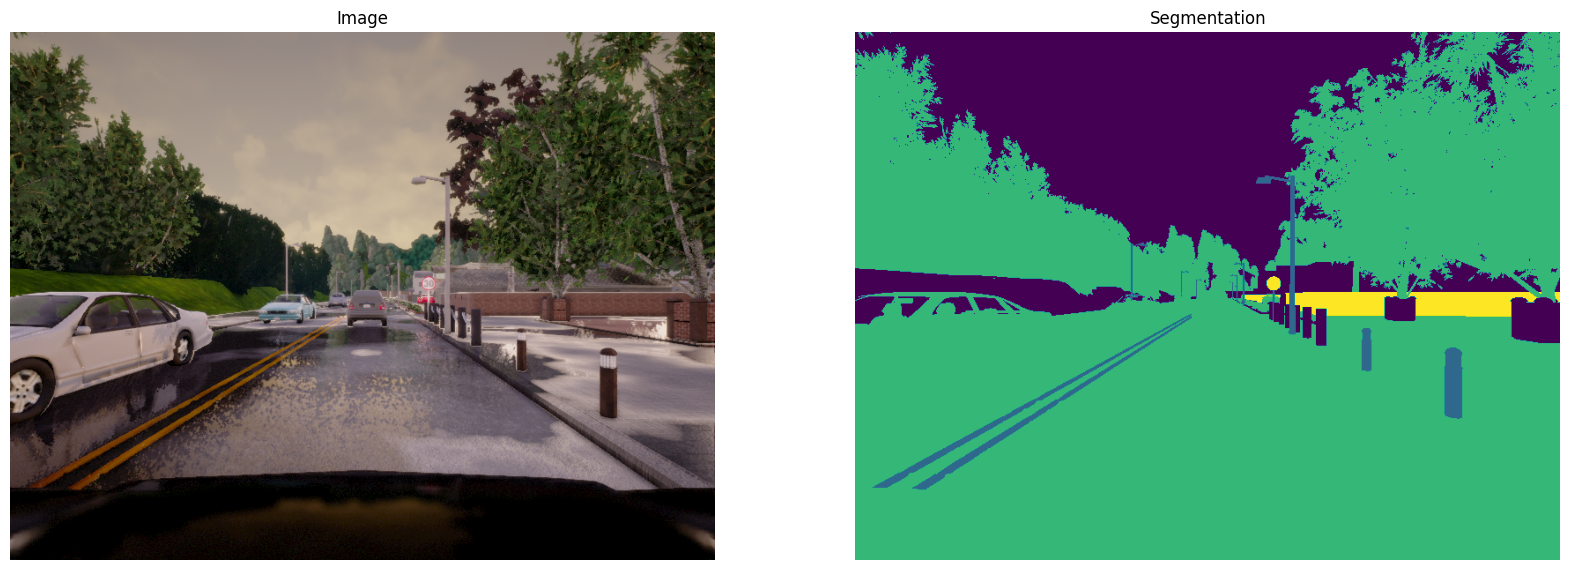

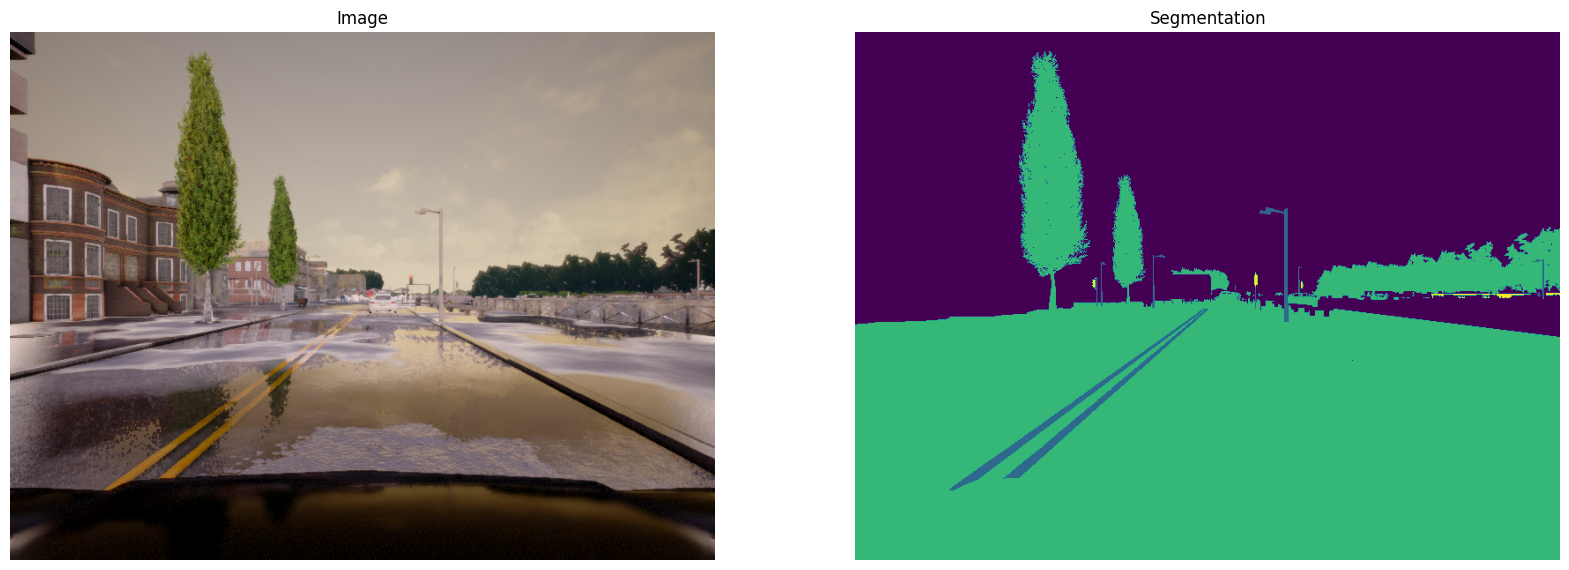

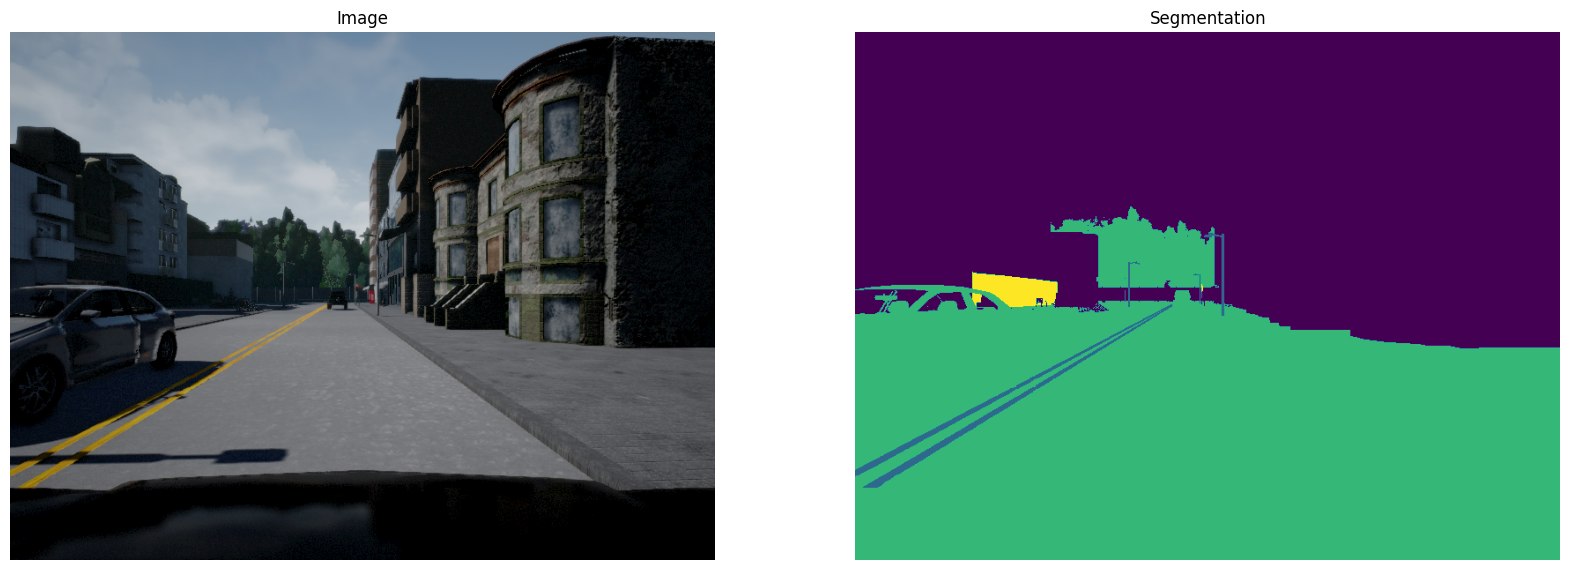

In [42]:
samples = 3
for i in range(samples):
    N = random.randint(0, number_of_images)
    img = cv2.imread(image_paths[N])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_paths[N], cv2.IMREAD_GRAYSCALE)
    fig, axes = plt.subplots(1, 2, figsize = (20, 8))
    axes[0].imshow(img)
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(mask)
    axes[1].set_title("Segmentation")
    axes[1].axis("off")

In [43]:
# Split the image and mask paths into training, validation and test sets.
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size= 0.8, random_state= 40)
validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size= 0.8, random_state= 40)
print(f"There are {len(train_image_paths)} images in the Training Set")
print(f'There are {len(validation_image_paths)} images in the Validation Set"')
print(f'There are {len(test_image_paths)} images in the Validation Set"')

There are 1600 images in the Training Set
There are 320 images in the Validation Set"
There are 80 images in the Validation Set"


In [44]:
def read_image(image_path, mask_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return image, mask

In [45]:
#Create a data generator function to read and load images and mask in batches
def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    return dataset


In [46]:
batch_size = 32
buffer_size = 500
train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, buffer_size, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size)

# Model Architecture


The U-Net is shaped like a letter U with an encoder, decoder, and the skip connections between them.


In [47]:
def decoding_block(inputs, skip_connection_input, filters):
    """
    Convolutional decoding/upsampling block
    
    Arguments:
        inputs -- Input tensor from previous layer
        skip_connection_input -- Input tensor from previous skip layer
        filters -- Number of filters for the convolutional layers
    Returns: 
        C -- Tensor output
    """

    CT = Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)
    
    residual_connection = concatenate([CT, skip_connection_input], axis=3)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    
  
    return C

In [48]:
def encoding_block(inputs, filters, dropout_probability=0, max_pooling=True):

    """
    Convolutional encoding/downsampling block
    
    Arguments:
        inputs -- Input tensor
        filters -- Number of filters for the convolutional layers
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection inputs 
    """
    
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    skip_connection = C  # Set aside residual
    
    # if max_pooling is True, add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(C)        
    else:
        next_layer = C
            
    return next_layer, skip_connection

In [49]:
def unet_model(input_size, filters, n_classes):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
        
    # Contracting Path (encoding)
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)
    
    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)
    
    # Expanding Path (decoding)
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)

    C10 = Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(U9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    C11 = Conv2D(filters = n_classes, kernel_size = (1,1), activation='sigmoid', padding='same')(C10)
    
    model = Model(inputs, outputs=C11)

    return model


In [50]:
model = unet_model((256, 256, 3), filters=32, n_classes=12)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 32)         128       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 32)         0         ['batch_normalization_18

In [51]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=2, verbose=1, min_lr = 2e-6)
batch_size = 64 
epochs = 5

In [16]:
history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/5
50/50 [==============================] - 2359s 47s/step - loss: 1.1762 - accuracy: 0.6808 - val_loss: 8.4937 - val_accuracy: 0.3763 - lr: 0.0010
Epoch 2/5
50/50 [==============================] - 2358s 47s/step - loss: 0.3394 - accuracy: 0.9022 - val_loss: 1.4484 - val_accuracy: 0.7070 - lr: 0.0010
Epoch 3/5
50/50 [==============================] - 2338s 47s/step - loss: 0.2602 - accuracy: 0.9221 - val_loss: 1.7903 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 4/5
50/50 [==============================] - 2410s 48s/step - loss: 0.2226 - accuracy: 0.9323 - val_loss: 1.1375 - val_accuracy: 0.7432 - lr: 0.0010
Epoch 5/5
50/50 [==============================] - 2365s 47s/step - loss: 0.1898 - accuracy: 0.9419 - val_loss: 0.7141 - val_accuracy: 0.8000 - lr: 0.0010


In [17]:
model.save("Unet_model1.h5")

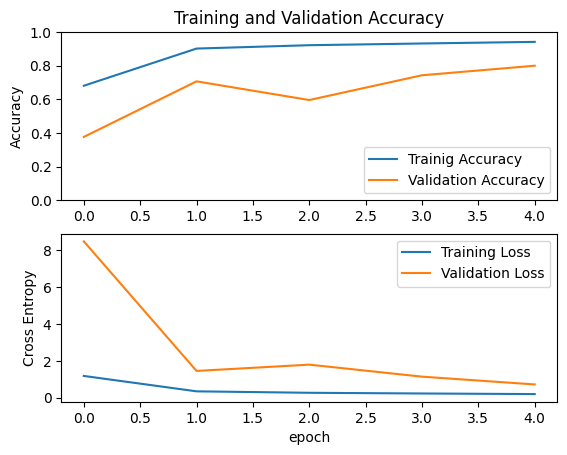

In [18]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.subplot(2, 1, 1)
plt.plot(acc, label = "Trainig Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.ylim([0, 1.0])
plt.legend(loc = "lower right")

plt.subplot(2, 1, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.ylabel("Cross Entropy")
plt.xlabel("epoch")
plt.legend(loc = "upper right")

plt.show()

In [52]:
# Displays the first image of each of the num batches
def display(display_list):
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()
def show_predictions(dataset, num, model):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        pred_mask = tf.expand_dims(tf.argmax(pred_mask, axis= -1), axis= -1)
        display([image[0], mask[0], pred_mask[0]])

In [ ]:
unet = load_model("Unet_model.h5")

In [ ]:
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)
        
    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)
        
    return true_masks, predicted_masks

1/1 [==============================] - 10s 10s/step


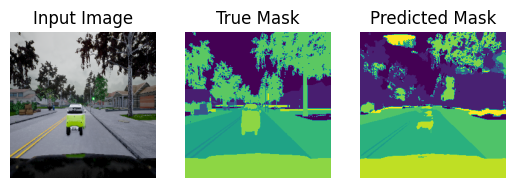

1/1 [==============================] - 7s 7s/step


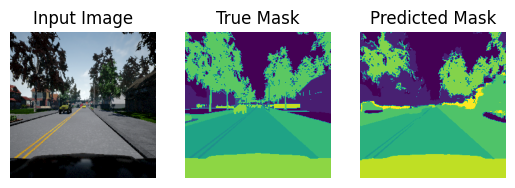

1/1 [==============================] - 4s 4s/step


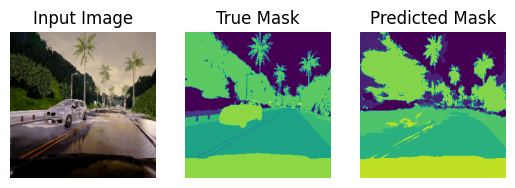

In [ ]:
show_predictions(test_dataset, num = 3, model = unet)

In [ ]:
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)
        
    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)
        
    return true_masks, predicted_masks

In [67]:
true_test_masks, predicted_test_masks = create_mask(validation_dataset, unet)

1/1 [==============================] - 7s 7s/step


In [68]:
true_test_masks = np.reshape(true_test_masks, -1)
predicted_test_masks = np.reshape(predicted_test_masks, -1)

In [69]:
cm = confusion_matrix(true_test_masks, predicted_test_masks)

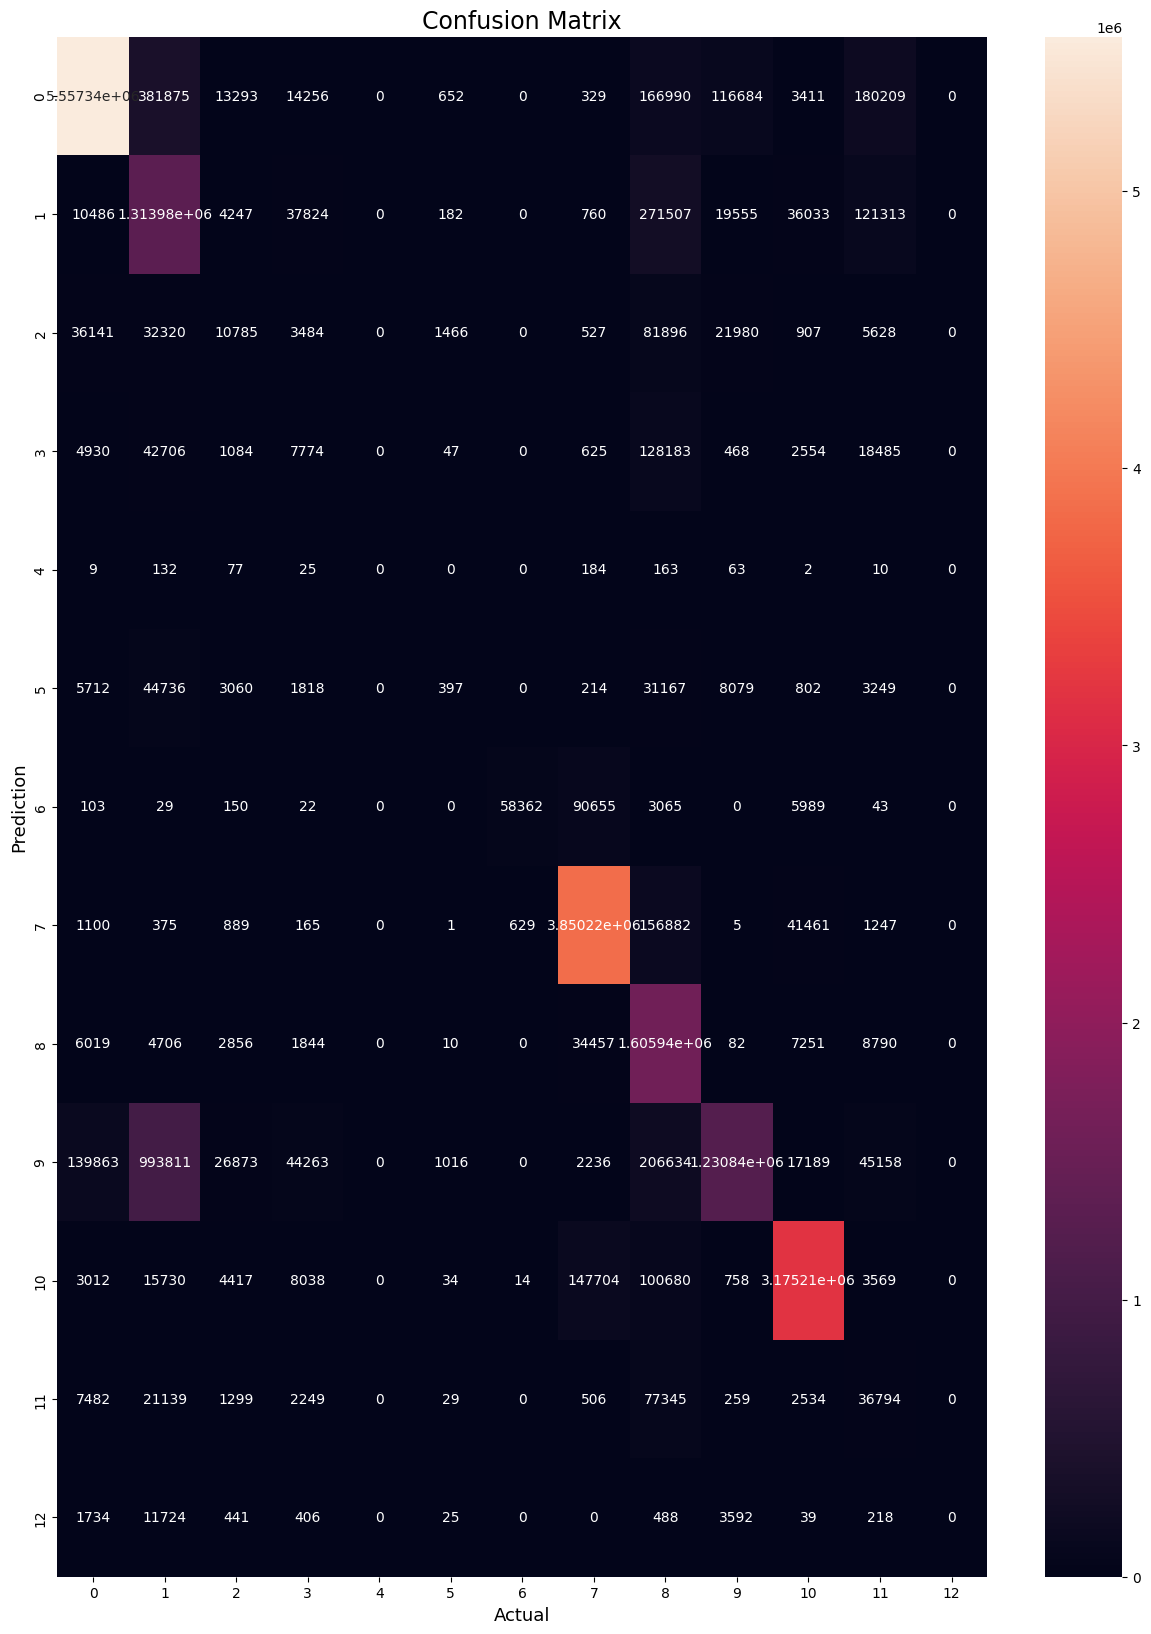

In [70]:
#Plot the confusion matrix.
plt.figure(figsize=(15, 20))
sns.heatmap(cm, 
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [71]:
accuracy_score(true_test_masks, predicted_test_masks)

0.8033584594726563